In [1]:
import os
os.chdir('..')
# os.chdir(os.path.dirname(__file__))
print(os.getcwd())

/workspace/rendering


In [11]:
from pathlib import Path


hov3_flame_number = 6000

filepaths_pkl = Path("data/HO3D_v3/train/").glob("*/meta/*.pkl")
filepaths_pkl_list = list(filepaths_pkl)
print(filepaths_pkl_list[0:5])
filepaths_bg = Path("data/HO3D_v3/train/").glob("*/rgb/*.jpg")
filepaths_bg_list = list(filepaths_bg)
print(filepaths_bg_list[0:5])

#max 0~20
object_number = 15
filepaths_obj = Path("data/models/").glob("*/textured_simple.obj")
filepaths_obj_list = list(filepaths_obj)
print(filepaths_obj_list[object_number])

[PosixPath('data/HO3D_v3/train/MDF11/meta/0000.pkl'), PosixPath('data/HO3D_v3/train/MDF11/meta/0001.pkl'), PosixPath('data/HO3D_v3/train/MDF11/meta/0002.pkl'), PosixPath('data/HO3D_v3/train/MDF11/meta/0003.pkl'), PosixPath('data/HO3D_v3/train/MDF11/meta/0004.pkl')]
[PosixPath('data/HO3D_v3/train/MDF11/rgb/0000.jpg'), PosixPath('data/HO3D_v3/train/MDF11/rgb/0001.jpg'), PosixPath('data/HO3D_v3/train/MDF11/rgb/0002.jpg'), PosixPath('data/HO3D_v3/train/MDF11/rgb/0003.jpg'), PosixPath('data/HO3D_v3/train/MDF11/rgb/0004.jpg')]
data/models/036_wood_block/textured_simple.obj


In [12]:
import pyredner # pyredner will be the main Python module we import for redner.
import torch # We also import PyTorch
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
from utils.utils import load_ho_meta, apply_transform_to_mesh
from utils.mano import ManoLayer


bg_img = np.array(Image.open(filepaths_bg_list[hov3_flame_number]), dtype=np.float32)/255.0
anno = load_ho_meta(filepaths_pkl_list[hov3_flame_number])

mano = ManoLayer()
mano_verts = mano(anno)

hand_joints = anno["handJoints3D"]
print(anno["handPose"].shape)
print(hand_joints.shape)
print(list(anno))

(48,)
(21, 3)
['handBeta', 'handTrans', 'handPose', 'handJoints3D', 'camMat', 'objRot', 'objTrans', 'camIDList', 'objCorners3D', 'objCorners3DRest', 'objName', 'objLabel', 'handVertContact', 'handVertDist', 'handVertIntersec', 'handVertObjSurfProj']


/workspace/rendering/utils/utils.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if v is None or v == 'None':


In [ ]:
# def read_hov3(hov3_dir, flame_num, objectfile):
#     bg_path = hov3_dir + "/rgb/" + str(flame_num) + ".jpg"
#     bg_img = np.array(Image.open(bg_path), dtype=np.float32)/255.0
#     meta_path = hov3_dir + "/meta/" + str(flame_num) + ".pkl"
#     anno = load_ho_meta(meta_path)
#     mano = ManoLayer()
#     mano_verts = mano(anno)
#     hand_joints = anno["handJoints3D"]
#     print(hand_joints.shape)

torch.int32
tensor([[615.4110,   0.0000, 310.5010],
        [  0.0000, 614.5840, 238.7980],
        [  0.0000,   0.0000,   1.0000]])
tensor(54.9469)
{'position': tensor([0., 0., 0.]), 'look_at': tensor([ 0.,  0., -1.]), 'up': tensor([0., 1., 0.]), '_fov': None, '_cam_to_world': None, 'world_to_cam': None, '_intrinsic_mat': tensor([[ 1.9232,  0.0000, -0.0148],
        [ 0.0000,  1.9206, -0.0025],
        [ 0.0000,  0.0000,  1.0000]]), 'intrinsic_mat_inv': tensor([[0.5200, -0.0000, 0.0077],
        [0.0000, 0.5207, 0.0013],
        [0.0000, 0.0000, 1.0000]]), 'distortion_params': None, 'clip_near': 0.0001, 'resolution': (480, 640), 'viewport': None, 'camera_type': CameraType.perspective}
torch.Size([7866, 3]) torch.Size([3, 3]) torch.Size([3])
Scene construction, time: 0.00580 s
Forward pass, time: 0.10955 s


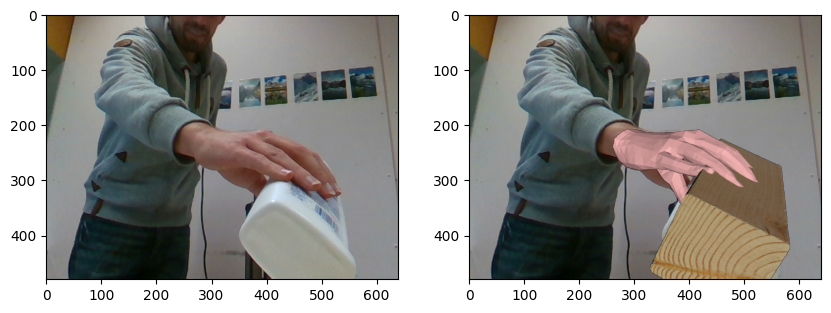

In [13]:
resolution = bg_img.shape[:2]

mano_object = pyredner.Object(
    vertices=mano_verts[0], 
    indices=mano.faces, 
    uvs=mano.uv,
    material=pyredner.Material(
        diffuse_reflectance=pyredner.Texture(mano.map.to(pyredner.get_device()))
        # diffuse_reflectance=torch.tensor((0.5, 0.5, 0.5), device=pyredner.get_device())))
    )
)
print(mano.faces.dtype)

world2cam = torch.eye(4)
R = torch.diag(torch.tensor([-1.,1.,-1.]))
world2cam[:3,:3] = R
cam2world = world2cam.inverse()
K = torch.tensor(anno['camMat'], dtype=torch.float32)
fx, fy = K.diagonal()[:2]
px, py = K[:2,2]
print(K)
intrinsic_mat = torch.tensor([
        [fx / resolution[1] * 2, 0.0000, px/resolution[1]-0.5],
        [0.0000, fy / resolution[1] * 2, py/resolution[0]-0.5],
        [0.0000, 0.0000, 1.0000]]
        )

fov = 2* torch.atan(0.5 * resolution[1] / K[0, 0]) * 180 / 3.1415926
print(fov)
camera = pyredner.Camera(
    intrinsic_mat=intrinsic_mat,
    # cam_to_world=cam2world,
    position = torch.tensor([0, 0, 0.], dtype=torch.float32),
    look_at = torch.tensor([0, 0, -1.], dtype=torch.float32),
    up = torch.tensor([0, 1., 0], dtype=torch.float32),
    # fov = torch.tensor([fov], dtype=torch.float32),
    resolution=resolution,
)
print(camera.__dict__)
dirlight = pyredner.DirectionalLight(
    direction = torch.tensor([0.0, 0.0, -1.0]), 
    intensity = torch.ones(3)*3.0,
)
# envmap = pyredner.EnvironmentMap(torch.tensor(bg_img))

# objects = pyredner.load_obj('data/models/002_master_chef_can/textured_simple.obj', return_objects=True)
objects = pyredner.load_obj(filepaths_obj_list[object_number], return_objects=True)
obj_object = pyredner.Object(
    vertices=apply_transform_to_mesh(objects[0].vertices, anno),
    indices=objects[0].indices, 
    uvs=objects[0].uvs,
    uv_indices=objects[0].uv_indices,
    material=objects[0].material
)

# create scene
scene = pyredner.Scene(
    camera = camera, 
    objects = [
        mano_object, 
        obj_object,
        ]
    )

# Render the scene.
# render = pyredner.render_albedo(scene, alpha=True)
render = pyredner.render_deferred(scene, lights=[dirlight], alpha=True)
    

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(bg_img)
axs[1].imshow(bg_img)
axs[1].imshow(torch.pow(render, 1.0/2.2).cpu())